In [20]:
import pandas as pd 
import numpy as np 
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [21]:
#convert percentages to 
def convert(arr):
    array = []
    for i,item in enumerate(arr):
        if item > 0.5:
            array.append(True)
        else:
            array.append(False)
    return array

#function to calculate Top 15 All-NBA players
def grabTop15Players(dataframe1,predictions):
    guard_counter = 0
    forward_counter = 0
    center_counter = 0
    top_all_nba = []
    true_all_NBA = dataframe1.loc[dataframe1["All_NBA"] == True,"Player"]

    dataframe1["Predicted_Prob"] = predictions
    filtered_df = dataframe1.reindex(columns=["Player","Pos","Predicted_Prob"])
    sorted_filtered = filtered_df.sort_values(by='Predicted_Prob',ascending=False)
    print(sorted_filtered)

    for player in range(len(sorted_filtered.index)):
        if sorted_filtered.iloc[player,:]["Pos"] == "PG" or sorted_filtered.iloc[player,:]["Pos"] == "SG":
            if(guard_counter < 6):
                top_all_nba.append(sorted_filtered.iloc[player,:]["Player"])
                guard_counter += 1
        elif sorted_filtered.iloc[player,:]["Pos"] == "SF" or sorted_filtered.iloc[player,:]["Pos"] == "PF":
            if(forward_counter < 6):
                top_all_nba.append(sorted_filtered.iloc[player,:]["Player"])
                forward_counter += 1
        elif sorted_filtered.iloc[player,:]["Pos"] == "C":
            if(center_counter < 3):
                top_all_nba.append(sorted_filtered.iloc[player,:]["Player"])
                center_counter += 1
    print("True Top 15 Players:",true_all_NBA)
    print("Predicted Top 15 Players:", top_all_nba)
    wrong_predict_players = [players for players in top_all_nba if players not in true_all_NBA.unique()]
    print("Top 15 predicted players who didn't make All-NBA:", wrong_predict_players)
    print()
    missed_players = [players for players in true_all_NBA.unique() if players not in top_all_nba]
    print("Top 15 players who werent predicted top 15:",missed_players)
    print()
    print("Percent correct of Top 15 Players:",(15-len(wrong_predict_players))/15)  


In [22]:
train_data = pd.read_csv("full_training_data_1988-2016")
test_data = pd.read_csv("testing_data_2017-2020")

x_train = train_data.iloc[:,1:-1]
x_train = x_train.drop(["Player","Pos","Tm"],axis=1)
y_train = train_data["All_NBA"]

x_test = test_data.iloc[:,1:-1]
x_test = x_test.drop(["Player","Pos","Tm"],axis=1)
y_test = test_data["All_NBA"]



Running XGBoost Algorithm on all test data

In [23]:
#running xgboost on all data
train_dmatrix = xgb.DMatrix(x_train,label=y_train)
test_all_dmatrix = xgb.DMatrix(x_test,label=y_test)

params_all = {
    'max_depth':6,
    'min_child_height':1,
    'eta':0.3,
    'objective':"binary:logistic",
    'subsample':1,
    'colsample_bytree':1,
    'scale_pos_weight':28,
    'eval_metric':"logloss",
}

# boost_tree = xgb.XGBClassifier(scale_pos_weight = 28)
boost_tree_all = xgb.train(
    params_all,
    train_dmatrix,
    num_boost_round=999,
    evals=[(test_all_dmatrix,"Test")],
    early_stopping_rounds=10
)

print("Best MAE: {0:f} with {1} rounds".format(boost_tree_all.best_score,boost_tree_all.best_iteration + 1))



[18:28:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.45445
[1]	Test-logloss:0.32564
[2]	Test-logloss:0.24299
[3]	Test-logloss:0.19071
[4]	Test-logloss:0.15117
[5]	Test-logloss:0.12448
[6]	Test-logloss:0.10391
[7]	Test-logloss:0.09105
[8]	Test-logloss:0.08249
[9]	Test-logloss:0.07414
[10]	Test-logloss:0.06881
[11]	Test-logloss:0.06649
[12]	Test-logloss:0.06229
[13]	Test-logloss:0.06082
[14]	Test-logloss:0.05806
[15]	Test-logloss:0.05690
[16]	Test-logloss:0.05423
[17]	Test-logloss:0.05119
[18]	Test-logloss:0.05076
[19]	Test-logloss:0.05099
[20]	Test-logloss:0.05159
[21]	Test-logloss:0.05136
[22]	Test-logloss:0.05109
[23]	Test-logloss

In [24]:
# Define hyperparameters max_depth and min_child_weight
grid_search_params = [(max_depth,min_child_weight) 
    for max_depth in range(5,12) 
    for min_child_weight in range(5,10)
]

min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in grid_search_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params_all['max_depth'] = max_depth
    params_all['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params_all,
        train_dmatrix,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_logloss))
#Best params: 8, 9, logloss: 0.0508414
params_all["max_depth"] = best_params[0]
params_all["min_child_weight"] = best_params[1]




iforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	MAE 0.053190400000000006 for 29 rounds
CV with max_depth=7, min_child_weight=6
[18:29:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may 

In [25]:
#Define hyperparameters for subsample and colsample
grid_search_params = [(subsample, colsample) 
    for subsample in [i/10. for i in range(7,11)]
    for colsample in[i/10. for i in range(7,11)]
]

min_logloss = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(grid_search_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params_all['subsample'] = subsample
    params_all['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params_all,
        train_dmatrix,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tlogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample,colsample)
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_logloss))
#Best params: 1.0, 0.9, logloss: 0.051815
params_all["subsample"] = best_params[0]
params_all["colsample"] = best_params[1]



CV with subsample=1.0, colsample=1.0
[18:31:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:31:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:31:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { min_child_height } might not be used.

  This may not be

In [26]:
#Define hyperparameters for eta
min_logloss = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params_all['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params_all,
            train_dmatrix,
            num_boost_round=999,
            seed=42,
            nfold=5,
            metrics=['logloss'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tlogloss {} for {} rounds\n".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta
print("Best params: {}, logloss: {}".format(best_params, min_logloss))
#Best params: 0.01, logloss: 0.049323799999999994
params_all["eta"] = best_params

CV with eta=0.3
[18:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  Thi

In [27]:
print(params_all)
#{'max_depth': 8, 'min_child_height': 1, 'eta': 0.05, 'objective': 'binary:logistic', 'subsample': 1.0, 'colsample_bytree': 0.7, 'scale_pos_weight': 28, 'eval_metric': 'logloss', 'min_child_weight': 9, 'colsample': 0.8}
# params_all = {'max_depth': 8,'min_child_height': 1,'eta': 0.05, 'objective': 'binary:logistic', 'subsample': 1.0, 'colsample_bytree': 0.7, 'scale_pos_weight': 28, 'eval_metric': 'logloss', 'min_child_weight': 9, 'colsample': 0.8}

{'max_depth': 8, 'min_child_height': 1, 'eta': 0.05, 'objective': 'binary:logistic', 'subsample': 1.0, 'colsample_bytree': 0.7, 'scale_pos_weight': 28, 'eval_metric': 'logloss', 'min_child_weight': 9, 'colsample': 0.8}


In [28]:
#test model built on all data
predictions = boost_tree_all.predict(test_all_dmatrix)
predictions = pd.Series(convert(predictions))
test_data_copy = test_data.copy()
test_data_copy["Predicted_All_NBA"] = predictions

print(accuracy_score(y_test,predictions))
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data_copy.loc[(test_data.All_NBA == False) & (test_data_copy.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data_copy.loc[(test_data.All_NBA == True) & (test_data_copy.Predicted_All_NBA == False),"Player"])
print()


0.9832134292565947

35            Bradley Beal
86             Mike Conley
89        DeMarcus Cousins
167          Blake Griffin
184         Gordon Hayward
204          Dwight Howard
214           Kyrie Irving
265         Damian Lillard
273             Kyle Lowry
350             Chris Paul
433     Karl-Anthony Towns
597       DeMarcus Cousins
625         Andre Drummond
724           Kyrie Irving
748           Nikola Jokić
881             Chris Paul
936            Ben Simmons
983           Kemba Walker
1033     LaMarcus Aldridge
1114          Clint Capela
1137           Mike Conley
1151         Anthony Davis
1160         DeMar DeRozan
1172        Andre Drummond
1506    Karl-Anthony Towns
1518        Nikola Vučević
1701           Joel Embiid
1891       Khris Middleton
1991      Domantas Sabonis
2064      Hassan Whiteside
Name: Player, dtype: object

163     Draymond Green
1951        Chris Paul
2004     Pascal Siakam
2006       Ben Simmons
2019      Jayson Tatum
Name: Player, dtype: objec

Testing 2017 Data

In [29]:
#running XGBoost on 2017 data
test_data2017 = test_data[test_data["Year"] == 2017]
x_test2017 = test_data2017.iloc[:,1:-1]
x_test2017 = x_test2017.drop(["Player","Pos","Tm"],axis=1)
y_test2017 = test_data2017["All_NBA"]

test_dmatrix2017 = xgb.DMatrix(x_test2017,y_test2017)

params_2017 = params_all

boost_tree_2017 = xgb.train(
    params_2017,
    train_dmatrix,
    num_boost_round=999,
    evals=[(test_dmatrix2017,"Test")],
    early_stopping_rounds=10
)

print("Best MAE: {0:f} with {1} rounds".format(boost_tree_2017.best_score,boost_tree_2017.best_iteration + 1))
num_boost_round = boost_tree_2017.best_iteration + 1 



[18:37:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64995
[1]	Test-logloss:0.60936
[2]	Test-logloss:0.57291
[3]	Test-logloss:0.53976
[4]	Test-logloss:0.50905
[5]	Test-logloss:0.48058
[6]	Test-logloss:0.45423
[7]	Test-logloss:0.43005
[8]	Test-logloss:0.40775
[9]	Test-logloss:0.38734
[10]	Test-logloss:0.36854
[11]	Test-logloss:0.35069
[12]	Test-logloss:0.33388
[13]	Test-logloss:0.31862
[14]	Test-logloss:0.30462
[15]	Test-logloss:0.29074
[16]	Test-logloss:0.27813
[17]	Test-logloss:0.26604
[18]	Test-logloss:0.25570
[19]	Test-logloss:0.24533
[20]	Test-logloss:0.23599
[21]	Test-logloss:0.22689
[22]	Test-logloss:0.21830
[23]	T

In [30]:
#training XGBoost on 2017 data after finding proper number of trees
best_model_2017 = xgb.train(
    params_2017,
    train_dmatrix,
    num_boost_round = num_boost_round,
    evals=[(test_dmatrix2017,"Test")]
)

[18:37:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64995
[1]	Test-logloss:0.60936
[2]	Test-logloss:0.57291
[3]	Test-logloss:0.53976
[4]	Test-logloss:0.50905
[5]	Test-logloss:0.48058
[6]	Test-logloss:0.45423
[7]	Test-logloss:0.43005
[8]	Test-logloss:0.40775
[9]	Test-logloss:0.38734
[10]	Test-logloss:0.36854
[11]	Test-logloss:0.35069
[12]	Test-logloss:0.33388
[13]	Test-logloss:0.31862
[14]	Test-logloss:0.30462
[15]	Test-logloss:0.29074
[16]	Test-logloss:0.27813
[17]	Test-logloss:0.26604
[18]	Test-logloss:0.25570
[19]	Test-logloss:0.24533
[20]	Test-logloss:0.23599
[21]	Test-logloss:0.22689
[22]	Test-logloss:0.21830
[23]	T

In [40]:
#test model built on 2017 data
predictions = best_model_2017.predict(test_dmatrix2017)
predictions_bool = pd.Series(convert(predictions))
test_data2017_copy = test_data2017.copy()
test_data2017_copy.insert(len(test_data2017_copy.columns),"Predicted_All_NBA",predictions_bool)


print()
print(accuracy_score(y_test2017,predictions_bool))
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2017_copy.loc[(test_data2017_copy.All_NBA == False) & (test_data2017_copy.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2017_copy.loc[(test_data2017_copy.All_NBA == True) & (test_data2017_copy.Predicted_All_NBA == False),"Player"])
print()
print("************************")

#testing top 15 of 2017 model
grabTop15Players(test_data2017_copy,predictions)




0.9732510288065843

35           Bradley Beal
86            Mike Conley
89       DeMarcus Cousins
167         Blake Griffin
184        Gordon Hayward
204         Dwight Howard
214          Kyrie Irving
265        Damian Lillard
273            Kyle Lowry
350            Chris Paul
433    Karl-Anthony Towns
460      Hassan Whiteside
Name: Player, dtype: object

163    Draymond Green
Name: Player, dtype: object

************************
                Player Pos  Predicted_All_NBA
457  Russell Westbrook  PG           0.998250
219       LeBron James  SF           0.998148
171       James Harden  PG           0.997722
118       Kevin Durant  PF           0.997192
260      Kawhi Leonard  SF           0.997065
..                 ...  ..                ...
240        Cory Joseph  PG           0.000561
339       Kelly Olynyk   C           0.000559
476       Delon Wright  PG           0.000558
329     Lucas Nogueira   C           0.000557
349  Patrick Patterson  PF           0.000549

[486 rows

Testing on 2018 data

In [36]:
#running XGBoost on 2018 data
test_data2018 = test_data[test_data["Year"] == 2018]
x_test2018 = test_data2018.iloc[:,1:-1]
x_test2018 = x_test2018.drop(["Player","Pos","Tm"],axis=1)
y_test2018 = test_data2018["All_NBA"]

test_dmatrix2018 = xgb.DMatrix(x_test2018,y_test2018)

params_2018 = params_all

boost_tree_2018 = xgb.train(
    params_2018,
    train_dmatrix,
    num_boost_round=999,
    evals=[(test_dmatrix2018,"Test")],
    early_stopping_rounds=10
)

print("Best Logloss: {0:f} with {1} rounds".format(boost_tree_2018.best_score,boost_tree_2018.best_iteration + 1))
num_boost_round = boost_tree_2018.best_iteration + 1


[18:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64807
[1]	Test-logloss:0.60674
[2]	Test-logloss:0.56847
[3]	Test-logloss:0.53453
[4]	Test-logloss:0.50245
[5]	Test-logloss:0.47239
[6]	Test-logloss:0.44542
[7]	Test-logloss:0.42057
[8]	Test-logloss:0.39764
[9]	Test-logloss:0.37599
[10]	Test-logloss:0.35642
[11]	Test-logloss:0.33786
[12]	Test-logloss:0.32077
[13]	Test-logloss:0.30427
[14]	Test-logloss:0.28917
[15]	Test-logloss:0.27480
[16]	Test-logloss:0.26152
[17]	Test-logloss:0.24937
[18]	Test-logloss:0.23808
[19]	Test-logloss:0.22692
[20]	Test-logloss:0.21658
[21]	Test-logloss:0.20679
[22]	Test-logloss:0.19789
[23]	T

In [37]:
#training XGBoost on 2018 data after finding proper number of trees
best_model_2018 = xgb.train(
    params_2018,
    train_dmatrix,
    num_boost_round = num_boost_round,
    evals=[(test_dmatrix2018,"Test")]
)

[18:40:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64807
[1]	Test-logloss:0.60674
[2]	Test-logloss:0.56847
[3]	Test-logloss:0.53453
[4]	Test-logloss:0.50245
[5]	Test-logloss:0.47239
[6]	Test-logloss:0.44542
[7]	Test-logloss:0.42057
[8]	Test-logloss:0.39764
[9]	Test-logloss:0.37599
[10]	Test-logloss:0.35642
[11]	Test-logloss:0.33786
[12]	Test-logloss:0.32077
[13]	Test-logloss:0.30427
[14]	Test-logloss:0.28917
[15]	Test-logloss:0.27480
[16]	Test-logloss:0.26152
[17]	Test-logloss:0.24937
[18]	Test-logloss:0.23808
[19]	Test-logloss:0.22692
[20]	Test-logloss:0.21658
[21]	Test-logloss:0.20679
[22]	Test-logloss:0.19789
[23]	T

In [41]:
#test model built on 2018 data
predictions = best_model_2018.predict(test_dmatrix2018)
predictions_bool = pd.Series(convert(predictions))

test_data2018_copy = test_data2018.copy()
test_data2018_copy.insert(len(test_data2018_copy.columns),"Predicted_All_NBA",predictions_bool.values)

print()
print(accuracy_score(y_test2018,predictions_bool)) 
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2018_copy.loc[(test_data2018_copy.All_NBA == False) & (test_data2018_copy.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2018_copy.loc[(test_data2018_copy.All_NBA == True) & (test_data2018_copy.Predicted_All_NBA == False),"Player"])
print()

#testing top 15 of 2018 model
grabTop15Players(test_data2018_copy,predictions)



0.987037037037037

597    DeMarcus Cousins
625      Andre Drummond
724        Kyrie Irving
748        Nikola Jokić
881          Chris Paul
983        Kemba Walker
Name: Player, dtype: object

658    Paul George
Name: Player, dtype: object

                    Player Pos  Predicted_All_NBA
733           LeBron James  PF           0.998715
607          Anthony Davis  PF           0.998216
501  Giannis Antetokounmpo  PF           0.997509
679           James Harden  SG           0.997464
628           Kevin Durant  SF           0.996547
..                     ...  ..                ...
794           Shelvin Mack  PG           0.000434
858        Frank Ntilikina  PG           0.000434
876            Tony Parker  PG           0.000434
649           De'Aaron Fox  PG           0.000434
650            Tim Frazier  PG           0.000434

[540 rows x 3 columns]
True Top 15 Players: 492        LaMarcus Aldridge
501    Giannis Antetokounmpo
564             Jimmy Butler
605            Stephen Curr

Testing on 2019 Data

In [42]:
#running XGBoost on 2019 data
test_data2019 = test_data[test_data["Year"] == 2019]
x_test2019 = test_data2019.iloc[:,1:-1]
x_test2019 = x_test2019.drop(["Player","Pos","Tm"],axis=1)
y_test2019 = test_data2019["All_NBA"]

test_dmatrix2019 = xgb.DMatrix(x_test2019,y_test2019)

params_2019 = params_all

boost_tree_2019 = xgb.train(
    params_2019,
    train_dmatrix,
    num_boost_round=999,
    evals=[(test_dmatrix2019,"Test")],
    early_stopping_rounds=10
)

print("Best MAE: {0:f} with {1} rounds".format(boost_tree_2019.best_score,boost_tree_2019.best_iteration + 1))
num_boost_round = boost_tree_2019.best_iteration + 1

[18:46:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64782
[1]	Test-logloss:0.60767
[2]	Test-logloss:0.57039
[3]	Test-logloss:0.53715
[4]	Test-logloss:0.50599
[5]	Test-logloss:0.47637
[6]	Test-logloss:0.44960
[7]	Test-logloss:0.42574
[8]	Test-logloss:0.40366
[9]	Test-logloss:0.38270
[10]	Test-logloss:0.36316
[11]	Test-logloss:0.34545
[12]	Test-logloss:0.32868
[13]	Test-logloss:0.31260
[14]	Test-logloss:0.29780
[15]	Test-logloss:0.28373
[16]	Test-logloss:0.27144
[17]	Test-logloss:0.25979
[18]	Test-logloss:0.24880
[19]	Test-logloss:0.23821
[20]	Test-logloss:0.22804
[21]	Test-logloss:0.21841
[22]	Test-logloss:0.20933
[23]	T

In [43]:
#training XGBoost on 2019 data after finding proper number of trees
best_model_2019 = xgb.train(
    params_2019,
    train_dmatrix,
    num_boost_round = num_boost_round,
    evals=[(test_dmatrix2019,"Test")]
)

[18:46:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64782
[1]	Test-logloss:0.60767
[2]	Test-logloss:0.57039
[3]	Test-logloss:0.53715
[4]	Test-logloss:0.50599
[5]	Test-logloss:0.47637
[6]	Test-logloss:0.44960
[7]	Test-logloss:0.42574
[8]	Test-logloss:0.40366
[9]	Test-logloss:0.38270
[10]	Test-logloss:0.36316
[11]	Test-logloss:0.34545
[12]	Test-logloss:0.32868
[13]	Test-logloss:0.31260
[14]	Test-logloss:0.29780
[15]	Test-logloss:0.28373
[16]	Test-logloss:0.27144
[17]	Test-logloss:0.25979
[18]	Test-logloss:0.24880
[19]	Test-logloss:0.23821
[20]	Test-logloss:0.22804
[21]	Test-logloss:0.21841
[22]	Test-logloss:0.20933
[23]	T

In [44]:
#test model built on 2019 data
predictions = best_model_2019.predict(test_dmatrix2019)
predictions_bool = pd.Series(convert(predictions))

test_data2019_copy = test_data2019.copy()
test_data2019_copy.insert(len(test_data2019_copy.columns),"Predicted_All_NBA",predictions_bool.values)

print()
print(accuracy_score(y_test2019,predictions_bool)) 
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2019_copy.loc[(test_data2019_copy.All_NBA == False) & (test_data2019_copy.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2019_copy.loc[(test_data2019_copy.All_NBA == True) & (test_data2019_copy.Predicted_All_NBA == False),"Player"])
print()

#testing top 15 of 2018 model
grabTop15Players(test_data2019_copy,predictions)


0.9849056603773585

1033     LaMarcus Aldridge
1065          Bradley Beal
1114          Clint Capela
1137           Mike Conley
1151         Anthony Davis
1172        Andre Drummond
1506    Karl-Anthony Towns
1518        Nikola Vučević
Name: Player, dtype: object

Series([], Name: Player, dtype: object)

                     Player Pos  Predicted_All_NBA
1043  Giannis Antetokounmpo  PF           0.998808
1231           James Harden  PG           0.997739
1175           Kevin Durant  SF           0.995482
1208            Paul George  SF           0.994411
1180            Joel Embiid   C           0.993547
...                     ...  ..                ...
1280           Josh Jackson  SG           0.000534
1278          Frank Jackson  PG           0.000534
1276          Wesley Iwundu  SF           0.000534
1291        Stanley Johnson  SF           0.000534
1296      Derrick Jones Jr.  SF           0.000531

[530 rows x 3 columns]
True Top 15 Players: 1043    Giannis Antetokounmpo
1149  

Testing on 2020 data

In [45]:
#running XGBoost on 2020 data
test_data2020 = test_data[test_data["Year"] == 2020]
x_test2020 = test_data2020.iloc[:,1:-1]
x_test2020 = x_test2020.drop(["Player","Pos","Tm"],axis=1)
y_test2020 = test_data2020["All_NBA"]

test_dmatrix2020 = xgb.DMatrix(x_test2020,y_test2020)

params_2020 = params_all

boost_tree_2020 = xgb.train(
    params_2020,
    train_dmatrix,
    num_boost_round=999,
    evals=[(test_dmatrix2020,"Test")],
    early_stopping_rounds=10
)

print("Best MAE: {0:f} with {1} rounds".format(boost_tree_2020.best_score,boost_tree_2020.best_iteration + 1))
num_boost_round = boost_tree_2020.best_iteration + 1

[18:47:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64807
[1]	Test-logloss:0.60821
[2]	Test-logloss:0.57074
[3]	Test-logloss:0.53847
[4]	Test-logloss:0.50714
[5]	Test-logloss:0.47737
[6]	Test-logloss:0.45012
[7]	Test-logloss:0.42587
[8]	Test-logloss:0.40368
[9]	Test-logloss:0.38300
[10]	Test-logloss:0.36312
[11]	Test-logloss:0.34433
[12]	Test-logloss:0.32710
[13]	Test-logloss:0.31030
[14]	Test-logloss:0.29533
[15]	Test-logloss:0.28069
[16]	Test-logloss:0.26737
[17]	Test-logloss:0.25553
[18]	Test-logloss:0.24434
[19]	Test-logloss:0.23282
[20]	Test-logloss:0.22231
[21]	Test-logloss:0.21262
[22]	Test-logloss:0.20366
[23]	T

In [46]:
#training XGBoost on 2020 data after finding proper number of trees
best_model_2020 = xgb.train(
    params_2020,
    train_dmatrix,
    num_boost_round = num_boost_round,
    evals=[(test_dmatrix2020,"Test")]
)

[18:47:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { colsample, min_child_height } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-logloss:0.64807
[1]	Test-logloss:0.60821
[2]	Test-logloss:0.57074
[3]	Test-logloss:0.53847
[4]	Test-logloss:0.50714
[5]	Test-logloss:0.47737
[6]	Test-logloss:0.45012
[7]	Test-logloss:0.42587
[8]	Test-logloss:0.40368
[9]	Test-logloss:0.38300
[10]	Test-logloss:0.36312
[11]	Test-logloss:0.34433
[12]	Test-logloss:0.32710
[13]	Test-logloss:0.31030
[14]	Test-logloss:0.29533
[15]	Test-logloss:0.28069
[16]	Test-logloss:0.26737
[17]	Test-logloss:0.25553
[18]	Test-logloss:0.24434
[19]	Test-logloss:0.23282
[20]	Test-logloss:0.22231
[21]	Test-logloss:0.21262
[22]	Test-logloss:0.20366
[23]	T

In [47]:
#test model built on 2020 data
predictions = best_model_2020.predict(test_dmatrix2020)
predictions_bool = pd.Series(convert(predictions))

test_data2020_copy = test_data2020.copy()
test_data2020_copy.insert(len(test_data2020_copy.columns),"Predicted_All_NBA",predictions_bool.values)

print()
print(accuracy_score(y_test2020,predictions_bool)) 
print()
#players predicted to be on All-NBA and were not on All-NBA
print(test_data2020_copy.loc[(test_data2020_copy.All_NBA == False) & (test_data2020_copy.Predicted_All_NBA == True),"Player"])
print()
#players predicted not to be on All-NBA and was listed on All-NBA
print(test_data2020_copy.loc[(test_data2020_copy.All_NBA == True) & (test_data2020_copy.Predicted_All_NBA == False),"Player"])
print()

#testing top 15 of 2018 model
grabTop15Players(test_data2020_copy,predictions)



0.9848771266540642

1701           Joel Embiid
1991      Domantas Sabonis
2032    Karl-Anthony Towns
2064      Hassan Whiteside
Name: Player, dtype: object

1951       Chris Paul
2004    Pascal Siakam
2006      Ben Simmons
2019     Jayson Tatum
Name: Player, dtype: object

                     Player Pos  Predicted_All_NBA
1568  Giannis Antetokounmpo  PF           0.998049
1805           LeBron James  PG           0.996978
1753           James Harden  SG           0.996366
1678          Anthony Davis  PF           0.996194
1849          Kawhi Leonard  SF           0.996113
...                     ...  ..                ...
1937              KZ Okpala  PF           0.000415
1566          Kyle Anderson  SF           0.000415
2034          Allonzo Trier  SG           0.000415
1821            Cory Joseph  PG           0.000411
1719         Markelle Fultz  PG           0.000400

[529 rows x 3 columns]
True Top 15 Players: 1568    Giannis Antetokounmpo
1637             Jimmy Butler
1678    

In [48]:
sorted_list_2017 = sorted(best_model_2017.get_fscore().items(),reverse=True,key=lambda item:item[1])
sorted_list_2018 = sorted(best_model_2018.get_fscore().items(),reverse=True,key=lambda item:item[1])
sorted_list_2019 = sorted(best_model_2019.get_fscore().items(),reverse=True,key=lambda item:item[1])
sorted_list_2020 = sorted(best_model_2020.get_fscore().items(),reverse=True,key=lambda item:item[1])


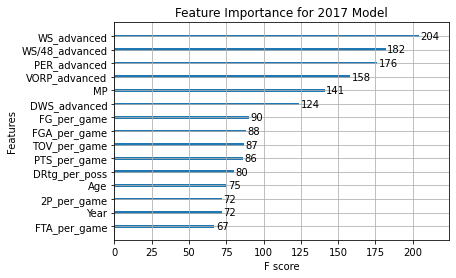

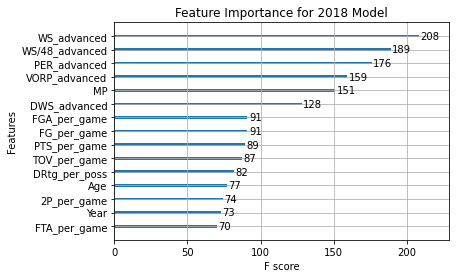

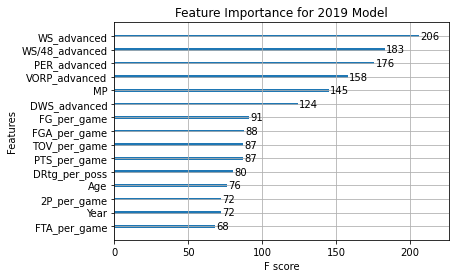

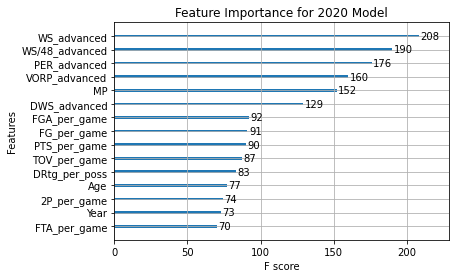

In [49]:
#plotting 2017 tree
# plt.figure()
# xgb.plot_tree(best_model_2017)
# plt.show()
graph_2017 = xgb.plot_importance(best_model_2017,max_num_features=15,title="Feature Importance for 2017 Model")

# #plotting 2018 tree
# plt.figure()
# xgb.plot_tree(best_model_2018)
# plt.show()
xgb.plot_importance(best_model_2018,max_num_features=15,title="Feature Importance for 2018 Model")

# #plotting 2017 tree
# plt.figure()
# xgb.plot_tree(best_model_2019)
# plt.show()
xgb.plot_importance(best_model_2019,max_num_features=15,title="Feature Importance for 2019 Model")

# #plotting 2020 tree
# plt.figure()
# xgb.plot_tree(best_model_2020)
# plt.show()
xgb.plot_importance(best_model_2020,max_num_features=15,title="Feature Importance for 2020 Model")



In [50]:
#saving models
best_model_2017.save_model("2017_xgboost.model")
best_model_2018.save_model("2018_xgboost.model")
best_model_2019.save_model("2019_xgboost.model")
best_model_2020.save_model("2020_xgboost.model")

Plotting Trees

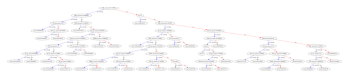

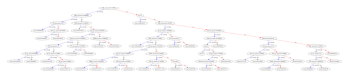

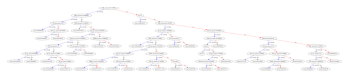

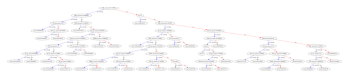

In [52]:
xgb.plot_tree(best_model_2017)
xgb.plot_tree(best_model_2018)
xgb.plot_tree(best_model_2019)
xgb.plot_tree(best_model_2020)